<a style="float:left;" href="https://colab.research.google.com/github/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-MNIST/Identification_ChiffresManuscrits_MNIST-PMC.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<br/>
### Rappel - Fonctionnement d'un carnet web iPython

* Pour exécuter le code contenu dans une cellule d'un carnet iPython, cliquez dans la cellule et faites (⇧↵, shift-enter);
* Le code d'un carnet iPython s'exécute séquentiellement de haut en bas de la page. Souvent, l'importation d'une bibliothèque Python ou l'initialisation d'une variable est préalable à l'exécution d'une cellule située plus bas. Il est donc recommandé d'exécuter les cellules en séquence. Enfin, méfiez-vous des retours en arrière qui peuvent réinitialiser certaines variables;
* Pour obtenir de l'information sur une fonction, utilisez la commande Python `help(`"nom de la fonction"`)`

# Identification de chiffres manuscrits - jeu de données MNIST
## Utilisation d'un perceptron multicouche (PMC)

#### Inspiration: 

Michael Nielsen, http://neuralnetworksanddeeplearning.com/

Grant Sanderson, https://www.youtube.com/watch?v=Ilg3gGewQ5U

## Importation des bibliothèques Python

In [45]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
print("TensorFlow version:",tf.__version__)
import keras
print("Keras version:",keras.__version__)

TensorFlow version: 2.9.2
Keras version: 2.9.0


## Fixer le hasard pour la reproductibilité

La mise au point de réseaux de neurones implique certains processus aléatoires. Afin de pouvoir reproduire et comparer vos résultats d'expérience, vous fixez temporairement l'état aléatoire grâce à un germe aléatoire unique.

Pendant la mise au point, vous fixez temporairement l'état aléatoire pour la reproductibilité mais vous répétez l'expérience avec différents germes ou états aléatoires et prenez la moyenne des résultats.
<br/>
##### **Note**: Pour un système en production, vous ravivez simplement l'état  purement aléatoire avec l'instruction `GERME_ALEATOIRE = None`

In [46]:
import os

# Définir un germe aléatoire
GERME_ALEATOIRE = 21

# Définir un état aléatoire pour Python
os.environ['PYTHONHASHSEED'] = str(GERME_ALEATOIRE)

# Définir un état aléatoire pour Python random
import random
random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour NumPy
import numpy as np
np.random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour TensorFlow
import tensorflow as tf
tf.random.set_seed(GERME_ALEATOIRE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

print("Germe aléatoire fixé")

Germe aléatoire fixé


## Jeu de données - chiffres manuscrits MNIST

Le jeu de données MNIST (Modified National Institute of Standards and Technology) comporte 60,000 images en tons de gris de 28×28 pixels de chiffres manuscrits étiquetés de 0 à 9. Site web: http://yann.lecun.com/exdb/mnist/

Il est incorporé dans keras.datasets 

### Lecture des données
### Séparation entre jeu de données d'entraînement et jeux de données de test

In [47]:
# le jeu de données MNIST
from keras.datasets import mnist

dic_noms_classe = { 
    0 : "0",
    1 : "1",
    2 : "2",
    3 : "3",
    4 : "4",
    5 : "5",
    6 : "6",
    7 : "7",
    8 : "8",
    9 : "9",
}

# lire le jeu de données MNIST et le diviser entre
# les données d'entrainement et les données de test
# MNIST est déjà divisé en un jeu de données d'entraînement (les 60 000 premières images) 
# et un jeu de données de test (les 10 000 dernières images).
(attributs_entrainement, classes_cibles_entrainement), (attributs_test, classes_cibles_test) = mnist.load_data()


## Exploration des données

### Portrait des données

In [48]:
# Portrait des données 
print()
print('Entraînement: attributs=%s, classes=%s' % (attributs_entrainement.shape, classes_cibles_entrainement.shape))
print('Test: attributs=%s, classes=%s' % (attributs_test.shape, classes_cibles_test.shape))


Entraînement: attributs=(60000, 28, 28), classes=(60000,)
Test: attributs=(10000, 28, 28), classes=(10000,)


### Visualisation de données


Quelques images avec leur étiquette de classe-cible...


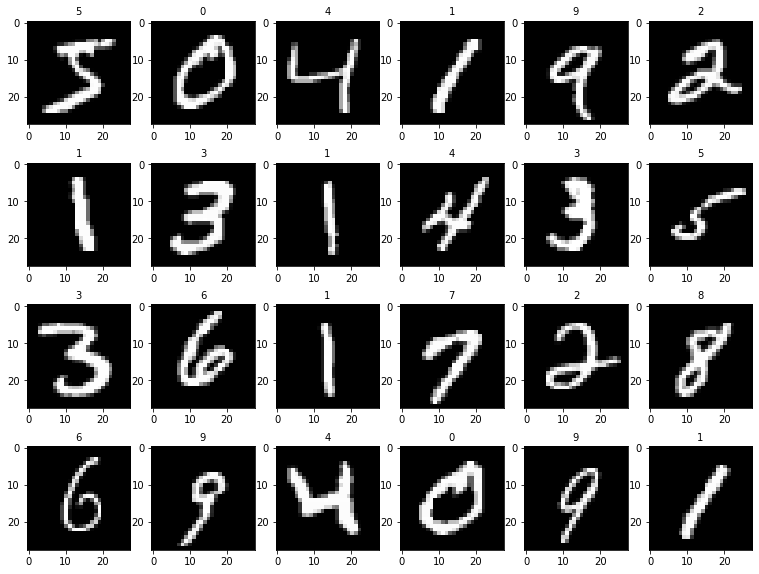

In [49]:
# Afficher les 24 premières images
print()
print("Quelques images avec leur étiquette de classe-cible...")
%matplotlib inline
# définir subplot
fig, axes = plt.subplots(nrows=4,ncols=6,figsize=(13,10))
for i_rangee in range(0,4):
    for i_colonne in range(0,6):
        axes[i_rangee,i_colonne].set_title(dic_noms_classe[int(classes_cibles_entrainement[i_rangee*6+i_colonne])],
                                           fontsize=10)
        axes[i_rangee,i_colonne].imshow(attributs_entrainement[i_rangee*6+i_colonne],cmap='gray')
plt.show()

## Préparation des données

### Linéariser les attributs des images 28 x 28 pixels en 784 attributs

In [50]:
# Linéariser les attributs des images 28 x 28 pixels en 784 attributs
print(attributs_entrainement.shape[1])
nombre_attributs = attributs_entrainement.shape[1]*attributs_entrainement.shape[1]
print("nombre_attributs:",nombre_attributs)
attributs_entrainement = attributs_entrainement.reshape(attributs_entrainement.shape[0], nombre_attributs)
attributs_test = attributs_test.reshape(attributs_test.shape[0], nombre_attributs)
print("Linéarisation des attributs des images terminée!")

28
nombre_attributs: 784
Linéarisation des attributs des images terminée!


### Conversion des étiquettes-cibles en vecteurs binaires à un bit discriminant

In [51]:
# Conversion des étiquettes-cibles en vecteurs binaires à un bit discriminant
from tensorflow.keras.utils import to_categorical
classes_cibles_entrainement = to_categorical(classes_cibles_entrainement)
print(classes_cibles_test)
classes_cibles_test = to_categorical(classes_cibles_test)
print(classes_cibles_test)
print("Conversion des étiquettes-cibles en vecteurs binaires terminée!")

[7 2 1 ... 4 5 6]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Conversion des étiquettes-cibles en vecteurs binaires terminée!


### Normalisation des images

In [52]:
# Normalisation
def normalisation(entrainement, test):
    # convertir de nombres entiers à nombres décimaux
    entrainement_normalise = entrainement.astype('float32')
    test_normalise = test.astype('float32')
    # normalisation à un nombre entre 0 et 1
    entrainement_normalise = entrainement_normalise / 255.0
    test_normalise = test_normalise / 255.0
    return entrainement_normalise, test_normalise

attributs_entrainement, attributs_test = normalisation(attributs_entrainement, attributs_test)

print("Normalisation des images terminée!")

Normalisation des images terminée!


## Construction d'un modèle de perceptron multicouche (PMC)

In [53]:
# Construction du modèle

from keras.models import Sequential
from keras.layers import Dense

print("Création d'un modèle de base...")

dimension_entree = (nombre_attributs,)
nombre_classes_cibles = 10

modele_de_base = Sequential()

# Apprentissage et extraction des attributs
modele_de_base.add(Dense(16, activation='relu', input_shape=dimension_entree))
modele_de_base.add(Dense(16, activation='relu'))

# Classification des images
modele_de_base.add(Dense(nombre_classes_cibles, 
                         activation='softmax'))

print()
print("Description du modèle de base:")
modele_de_base.summary()

Création d'un modèle de base...

Description du modèle de base:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                12560     
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 10)                170       
                                                                 
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


### Compilation du modèle

In [54]:
print()
print("Compilation du modèle...")

modele_de_base.compile(loss="categorical_crossentropy", 
                       optimizer="sgd", 
                       metrics=["accuracy"])

print("Modèle compilé!")


Compilation du modèle...
Modèle compilé!


## Entraînement du modèle

In [55]:
# Entraînement du modèle

print()
print("Entraînement du modèle...")

batch_size = 128
epochs = 20
taille_jeu_validation = 0.1

traces_entrainement = modele_de_base.fit(attributs_entrainement, 
                                         classes_cibles_entrainement,
                                         batch_size=batch_size,
                                         epochs=epochs,
                                         validation_split=taille_jeu_validation)


Entraînement du modèle...
Epoch 1/20
422/422 [==============================] - 3s 5ms/step - loss: 1.8151 - accuracy: 0.4208 - val_loss: 1.2041 - val_accuracy: 0.6815
Epoch 2/20
422/422 [==============================] - 2s 5ms/step - loss: 0.9041 - accuracy: 0.7514 - val_loss: 0.5971 - val_accuracy: 0.8475
Epoch 3/20
422/422 [==============================] - 2s 5ms/step - loss: 0.5718 - accuracy: 0.8402 - val_loss: 0.4191 - val_accuracy: 0.8843
Epoch 4/20
422/422 [==============================] - 2s 4ms/step - loss: 0.4556 - accuracy: 0.8715 - val_loss: 0.3525 - val_accuracy: 0.9007
Epoch 5/20
422/422 [==============================] - 2s 4ms/step - loss: 0.4016 - accuracy: 0.8855 - val_loss: 0.3184 - val_accuracy: 0.9078
Epoch 6/20
422/422 [==============================] - 2s 4ms/step - loss: 0.3705 - accuracy: 0.8933 - val_loss: 0.2964 - val_accuracy: 0.9148
Epoch 7/20
422/422 [==============================] - 2s 4ms/step - loss: 0.3496 - accuracy: 0.8988 - val_loss: 0.2800 - 

## Évaluation du modèle avec un jeu de données test

In [59]:
# Évaluation du modèle

print()
print("Évaluation du modèle...")

resultats = modele_de_base.evaluate(attributs_test, classes_cibles_test, verbose=0)
print("Exactitude test: {:.2f}%".format(resultats[1]*100))


Évaluation du modèle...
Exactitude test: 93.01%


**Note:** On constate une perte d'environ -1% entre l'exactitude sur le jeu de données de test et l'exactitude sur du jeu de données d'entraînement. Cette différence s'explique par le surajustement (en anglais, overfitting). 

## Affichage des courbes d'entraînement: erreur et exactitude

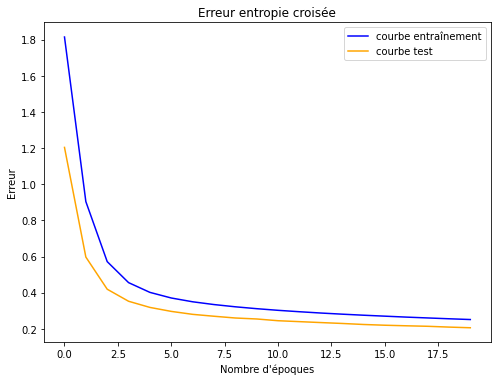

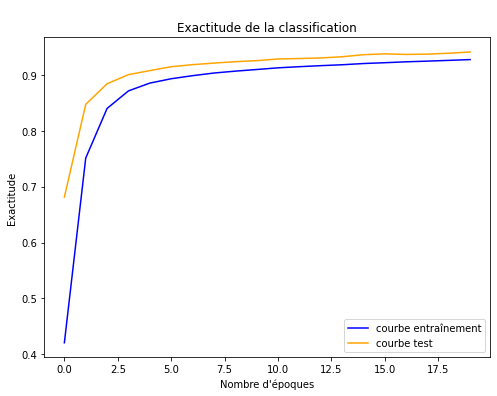

In [60]:
## Affichage des courbes d'entraînement
hauteur = 8
plt.subplots(figsize=(hauteur,1.618*hauteur))
plt.subplot(211)
plt.title('Erreur entropie croisée')
plt.plot(traces_entrainement.history['loss'], color='blue', label='courbe entraînement')
plt.plot(traces_entrainement.history['val_loss'], color='orange', label='courbe test')
plt.ylabel("Erreur")
plt.xlabel("Nombre d'époques")
plt.legend()
plt.show()
# tracer l'exactitude
plt.subplots(figsize=(hauteur,1.618*hauteur))
plt.subplot(212)
plt.title('\nExactitude de la classification')
plt.plot(traces_entrainement.history['accuracy'], color='blue', label='courbe entraînement')
plt.plot(traces_entrainement.history['val_accuracy'], color='orange', label='courbe test')
plt.ylabel("Exactitude")
plt.xlabel("Nombre d'époques")
plt.legend()
plt.show()

In [58]:
print("Exécution carnet IPython terminée!")

Exécution carnet IPython terminée!
